# Ndvi_ndmi-behaviour-bydate

Analyses NDVI or NDMI data by month throughout the years.

#### Planeación

-- Data treatment --
- Create datetime data (pd.to_datetime(month + year))
- Find season
    * winter = enero, febrero, marzo
    * sping = abril, mayo, junio
    * summer = julio, agosto, septiembre
    * fall = octubre, noviembre, diciembre

------- Data analysis ------- Graph 1 sola línea por ciudad -------
- Group by por date [with ndvi/ndmi mean]
- Plot

------- Data analysis ------- Graph Varias lineas, una por año -------
- Create figure
- For loop year by year:
    - Isolate df from that specific year
    - Group by month / Group by season [with ndvi/ndmi mean]
    - Plot

------- Data analysis ------- Mapas -------
- Separar en 4 dfs por season
- For loop:
    - Group by hex, [ndvi/ndmi mean]
    - Enlazar a geometría
    - Mapear


DATA STRUCTURE
1. hex_id
2. res
3. ndvi / ndmi
4. month = 1,2,3,4....
5. year = 2018, 2019, 2020, 2021, 2022

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/usr/local/python/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Data download

In [2]:
city = 'Monterrey'
analysis_type = 'ndvi'
res = 10

In [3]:
csvparaMave = True

### Data download - Municipality polygons

In [4]:
mun_schema = 'metropolis'
mun_table = 'metro_gdf'

query = f"SELECT * FROM {mun_schema}.{mun_table} WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')

print(mun_gdf.shape)
mun_gdf.head(2)

(18, 6)


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,city
0,19001,19,001,Abasolo,"POLYGON ((-100.39267 25.98715, -100.39224 25.9...",Monterrey
1,19006,19,006,Apodaca,"POLYGON ((-100.24794 25.86462, -100.24672 25.8...",Monterrey


### Data download - Hex grid

In [5]:
cvegeo_list = list(mun_gdf.loc[mun_gdf.city==city]["CVEGEO"].unique())
cvegeo_list

['19001',
 '19006',
 '19009',
 '19010',
 '19012',
 '19018',
 '19019',
 '19021',
 '19025',
 '19026',
 '19031',
 '19039',
 '19041',
 '19045',
 '19046',
 '19047',
 '19048',
 '19049']

In [6]:
# donwload hexagons
hex_grid = gpd.GeoDataFrame()
hex_grid_schema = 'hexgrid'
hex_grid_table = 'hexgrid_{}_city'.format(res)

# Iterates over municipality codes for each metropolitan area or capital
for cvegeo in cvegeo_list:
    # Downloads municipality polygon according to code
    query = f"SELECT * FROM {hex_grid_schema}.{hex_grid_table} WHERE \"CVEGEO\" LIKE \'{cvegeo}%%\'"
    hex_tmp = aup.gdf_from_query(query, geometry_col='geometry')
    hex_grid = pd.concat([hex_grid, hex_tmp],
    ignore_index = True, axis = 0)
print(hex_grid.shape)
hex_grid.head(2)

(433077, 3)


,geometry,hex_id_10,CVEGEO
0,"POLYGON ((-100.41858 25.95269, -100.41790 25.9...",8a48a2389b57fff,19001
1,"POLYGON ((-100.38946 25.93779, -100.38878 25.9...",8a48a2388167fff,19001


### Data download - Raster Analysis Data

In [7]:
# Info to query
raster_schema = 'raster_analysis'
raster_folder = '{}_complete_dataset_hex'.format(analysis_type)

# Query
query = f"SELECT * FROM {raster_schema}.{raster_folder} WHERE \"city\" LIKE \'{city}\' AND \"res\"={res}"
raster_dataset = aup.df_from_query(query)

print(raster_dataset.shape)
raster_dataset.head(2)

(4542300, 6)


,hex_id,res,ndvi,month,year,city
0,8a48a2051c4ffff,10,0.135363,1,2018,Monterrey
1,8a48a2053357fff,10,0.141822,1,2018,Monterrey


## Data treatment

Data treatment - Create datetime data

In [8]:
#Creates datetime data by adding month (string) + / + year (string)
raster_dataset['date'] = pd.to_datetime(raster_dataset['month'].astype(str) + '/' + raster_dataset['year'].astype(str))

#Strips the day, leaving month and year
raster_dataset['date'] = raster_dataset['date'].apply(lambda x: x.strftime('%Y-%m'))

#Show dataframe
print(raster_dataset.shape)
raster_dataset.head(2)

(4542300, 7)


,hex_id,res,ndvi,month,year,city,date
0,8a48a2051c4ffff,10,0.135363,1,2018,Monterrey,2018-01
1,8a48a2053357fff,10,0.141822,1,2018,Monterrey,2018-01


Data treatment - Name months

In [9]:
def name_month(month):
    if (month == 1):
        return 'jan'
    elif (month == 2):
        return 'feb'
    elif (month == 3):
        return 'mar'
    elif (month == 4):
        return 'apr'
    elif (month == 5):
        return 'may'
    elif (month == 6):
        return 'jun'
    elif (month == 7):
        return 'jul'
    elif (month == 8):
        return 'aug'
    elif (month == 9):
        return 'sep'
    elif (month == 10):
        return 'oct'
    elif (month == 11):
        return 'nov'
    elif (month == 12):
        return 'dec'
    else:
          return "N/A"

raster_dataset['month_str'] = raster_dataset['month'].apply(lambda x: name_month(x))
    
# Ordering months chronologically
categories = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul','aug', 'sep', 'oct', 'nov', 'dec']
raster_dataset['month_str'] = pd.Categorical(raster_dataset['month_str'], categories=categories, ordered=True)

#Show dataframe
print(raster_dataset.shape)
raster_dataset.head(2)

(4542300, 8)


,hex_id,res,ndvi,month,year,city,date,month_str
0,8a48a2051c4ffff,10,0.135363,1,2018,Monterrey,2018-01,jan
1,8a48a2053357fff,10,0.141822,1,2018,Monterrey,2018-01,jan


Data treatment - Create season data

In [10]:
def find_season(month):
    if (month == 1) or (month == 2) or (month == 3):
        return "winter"
    elif (month == 4) or (month == 5) or (month == 6):
        return "spring"
    elif (month == 7) or (month == 8) or (month == 9):
        return "summer"
    elif (month == 10) or (month == 11) or (month == 12):
        return "fall"
    else:
          return "N/A"

raster_dataset['season'] = raster_dataset['month'].apply(lambda x: find_season(x))

# Ordering seasons chronologically
categories = ['winter', 'spring', 'summer', 'fall']
raster_dataset['season'] = pd.Categorical(raster_dataset['season'], categories=categories, ordered=True)

#Show dataframe
print(raster_dataset.shape)
raster_dataset.head(2)

(4542300, 9)


,hex_id,res,ndvi,month,year,city,date,month_str,season
0,8a48a2051c4ffff,10,0.135363,1,2018,Monterrey,2018-01,jan,winter
1,8a48a2053357fff,10,0.141822,1,2018,Monterrey,2018-01,jan,winter


Clean data dropping NaNs, if any

In [11]:
raster_dataset = raster_dataset.dropna()

#Show dataframe
print(raster_dataset.shape)
raster_dataset.head(2)

(4542300, 9)


,hex_id,res,ndvi,month,year,city,date,month_str,season
0,8a48a2051c4ffff,10,0.135363,1,2018,Monterrey,2018-01,jan,winter
1,8a48a2053357fff,10,0.141822,1,2018,Monterrey,2018-01,jan,winter


### Celda para Mave

In [12]:
if csvparaMave:
    mave_raster_dataset = raster_dataset.copy()
    
    #Solo año 2022
    #mave_raster_dataset = mave_raster_dataset.loc[mave_raster_dataset.year==2022]
    
    #Show dataframe
    print(mave_raster_dataset.shape)
    mave_raster_dataset.head(2)

    #Download dataframe
    mave_raster_dataset.to_csv("../../../data/external/complete{}_{}_res{}".format(analysis_type,city.lower(),res))

(4542300, 9)


## Data analysis

### Data analysis - Graph one continuous behaviour

Group by date

In [13]:
mean_bydate = raster_dataset.groupby('date').agg({analysis_type:np.mean})
mean_bydate.head(2)

,ndvi
date,
2018-01,0.212360
2018-02,0.182649


Plot continuous behaviour

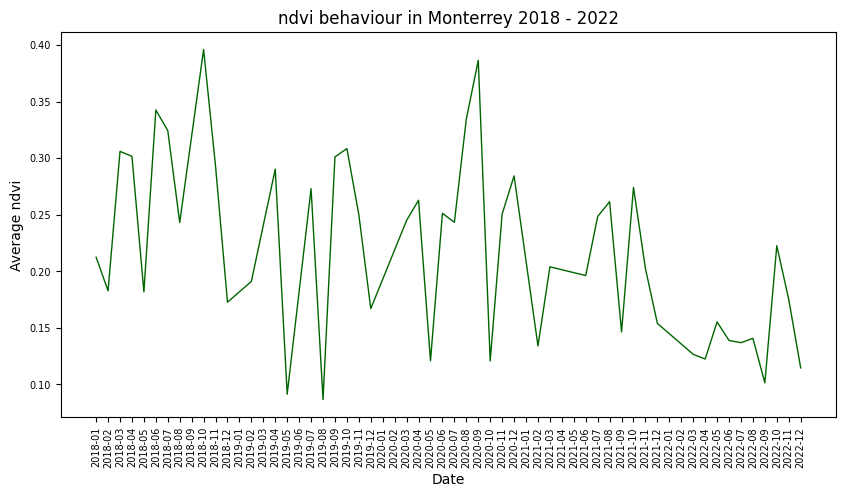

In [14]:
# ---------- Plot ----------
plt.figure(figsize=(10,5))
plt.plot(mean_bydate, '-', color = 'darkgreen',linewidth = 1);

# ---------- Format ----------
# Format - Titles
plt.title('{} behaviour in {} 2018 - 2022'.format(analysis_type,city))
plt.xlabel('Date')
plt.ylabel('Average {}'.format(analysis_type))

# Format - x ticks
x = plt.gca().xaxis
for item in x.get_ticklabels():
    item.set_rotation(90)
    item.set_size(7)
    
# Format - y ticks
y = plt.gca().yaxis
for item in y.get_ticklabels():
    item.set_size(7)
    
# Save plot
plt.savefig("../../../output/figures/ndvi_ndmi_marg_bycity/{}/{}_{}_2018-2022.svg".format(city.lower(),analysis_type,city.lower()))

### Data analysis - Graph yearly behaviour

In [15]:
#Show dataframe
print(raster_dataset.shape)
raster_dataset.head(2)

(4542300, 9)


,hex_id,res,ndvi,month,year,city,date,month_str,season
0,8a48a2051c4ffff,10,0.135363,1,2018,Monterrey,2018-01,jan,winter
1,8a48a2053357fff,10,0.141822,1,2018,Monterrey,2018-01,jan,winter


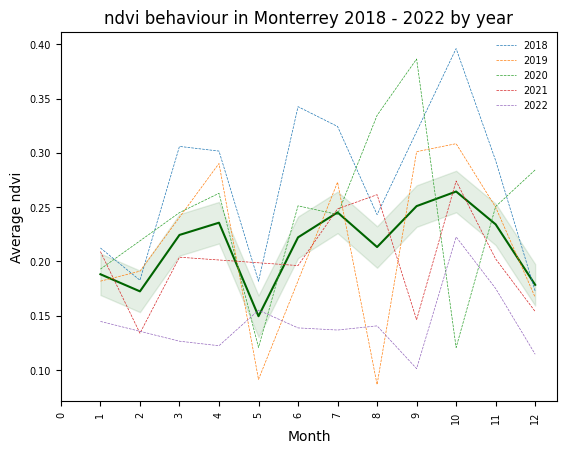

In [16]:
# ---------- Plotting whole data by month (main line) ----------
# Line data
complete_bymonth = raster_dataset.groupby('month').agg({analysis_type:np.mean,'month':np.mean})

#Confidence interval data
x = complete_bymonth.month
y = complete_bymonth['{}'.format(analysis_type)]
ci = 1.96 * np.std(y)/np.sqrt(len(x))

#Plot
fig, ax = plt.subplots()
ax.plot(x,y, color = 'darkgreen')
ax.fill_between(x, (y-ci), (y+ci), color='darkgreen', alpha=.1)

# ---------- Plotting yearly data by month (dotted lines) ----------

# Find all data years
available_years = list(raster_dataset['year'].unique())

#Iterate over each year
for current_year in available_years:
    #Isolating df
    current_raster_dataset = raster_dataset.loc[(raster_dataset.year == current_year)]
    #Grouping by month    
    yearly_bymonth = current_raster_dataset.groupby('month').agg({analysis_type:np.mean})
    #Plotting
    plt.plot(yearly_bymonth, '--', linewidth = 0.5, label=current_year);


# ---------- Format ----------
# Format - Titles
plt.title('{} behaviour in {} 2018 - 2022 by year'.format(analysis_type,city))
plt.xlabel('Month')
plt.ylabel('Average {}'.format(analysis_type))

# Format - x ticks
# Tag all 12 months
plt.xticks(np.arange(0, 13))
# Rotate ticks
x = plt.gca().xaxis
for item in x.get_ticklabels():
    item.set_rotation(90)
    item.set_size(7)
    
# Format - y ticks
y = plt.gca().yaxis
for item in y.get_ticklabels():
    item.set_size(7)
        
# Format - Legend
plt.legend(frameon=False,
           loc=1, 
           fontsize = 7)


# ---------- Save Plot ----------
plt.savefig("../../../output/figures/ndvi_ndmi_marg_bycity/{}/{}_{}_by_year.svg".format(city.lower(),analysis_type,city.lower()))

#### Old code, by season and no confidence interval

#CÓDIGO ANTERIOR: NO INCLUYE CONFIDENCE INTERVAL

plt.figure()

###### ---------- Plotting whole data by month (main line) ----------
##### Line data
complete_bymonth = raster_dataset.groupby('month_str').agg({analysis_type:np.mean})
plt.plot(complete_bymonth, '-', color = 'darkgreen', linewidth = 1, label='All');

##### ---------- Plotting yearly data by month (dotted lines) ----------

##### Find all data years
available_years = list(raster_dataset['year'].unique())

#Iterate over each year
for current_year in available_years:
    #Isolating df
    current_raster_dataset = raster_dataset.loc[(raster_dataset.year == current_year)]
    #Grouping by month    
    yearly_bymonth = current_raster_dataset.groupby('month_str').agg({analysis_type:np.mean})
    #Plotting
    plt.plot(yearly_bymonth, '--', linewidth = 0.5, label=current_year);


##### ---------- Format ----------
##### Format - Titles
plt.title('{} behaviour in {} 2018 - 2022 by month'.format(analysis_type,city))
plt.xlabel('Month')
plt.ylabel('Average {}'.format(analysis_type))

##### Format - x ticks
##### Tag all 12 months
plt.xticks(np.arange(0, 12))
##### Rotate ticks
x = plt.gca().xaxis
for item in x.get_ticklabels():
    item.set_rotation(90)
    item.set_size(7)
    
##### Format - y ticks
y = plt.gca().yaxis
for item in y.get_ticklabels():
    item.set_size(7)
        
##### Format - Legend
plt.legend(frameon=False,
           loc=1, 
           fontsize = 7)

##### Save plot
#plt.savefig("../../../output/figures/{}/{}_{}_each_year".format(analysis,analysis,city.lower()))

plt.figure()

##### ---------- Plotting whole data by month (main line) ----------
complete_byseason = raster_dataset.groupby('season').agg({analysis:np.mean})
plt.plot(complete_byseason, '-', color = 'darkgreen', linewidth = 1, label='All');

##### ---------- Plotting yearly data by month (dotted lines) ----------

##### Find all data years
available_years = list(raster_dataset['year'].unique())

#Iterate over each year
for current_year in available_years:
    #Isolating df
    current_raster_dataset = raster_dataset.loc[(raster_dataset.year == current_year)]
    #Grouping by month    
    yearly_byseason = current_raster_dataset.groupby('season').agg({analysis:np.mean})
    #Plotting
    plt.plot(yearly_byseason, '--', linewidth = 0.5, label=current_year);


    
##### ---------- Format ----------
##### Format - Titles
plt.title('{} behaviour in {} 2018 - 2022 by season'.format(analysis,city))
plt.xlabel('Month')
plt.ylabel('Average {}'.format(analysis))

##### Format - x ticks
##### Rotate ticks
x = plt.gca().xaxis
for item in x.get_ticklabels():
    item.set_rotation(90)
    item.set_size(7)
    
##### Format - y ticks
y = plt.gca().yaxis
for item in y.get_ticklabels():
    item.set_size(7)
        
##### Format - Legend
plt.legend(frameon=False,
           loc=1, 
           fontsize = 7)

# ---------- Save Plot ----------
plt.savefig("../../../output/figures/{}/{}_{}_by_season".format(analysis_type,analysis_type,city.lower()))

### Data analysis - Maps

Show dataframe and available unique hex_ids

In [17]:
#Show dataframe
print(raster_dataset.shape)

available_hexids = list(raster_dataset['hex_id'].unique())
print(len(available_hexids))

raster_dataset.head(2)

(4542300, 9)
75705


,hex_id,res,ndvi,month,year,city,date,month_str,season
0,8a48a2051c4ffff,10,0.135363,1,2018,Monterrey,2018-01,jan,winter
1,8a48a2053357fff,10,0.141822,1,2018,Monterrey,2018-01,jan,winter


In [18]:
if analysis_type == 'ndvi':
    divnorm=colors.TwoSlopeNorm(vmin=-0.2, vcenter=0.2, vmax=0.6)
    colorpalette = 'PiYG'
else:
    divnorm=colors.TwoSlopeNorm(vmin=-0.2, vcenter=0, vmax=0.2)
    colorpalette = 'BrBG'

Create maps by season

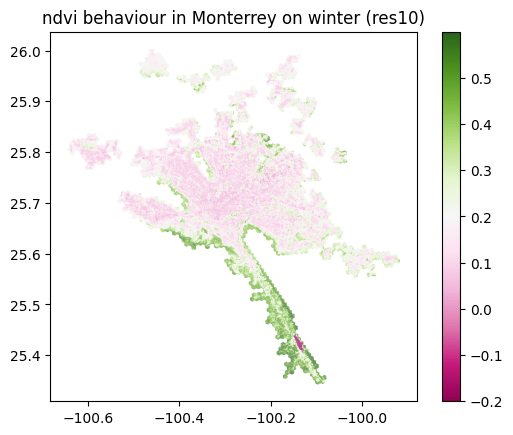

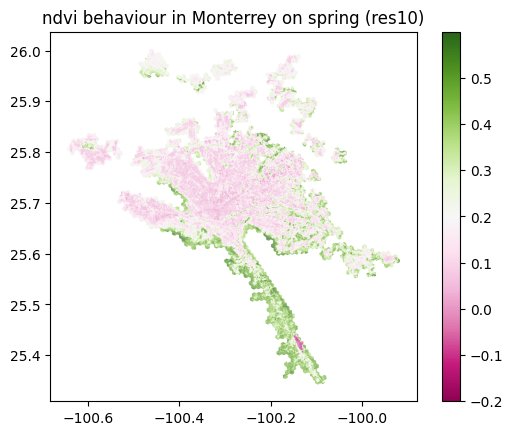

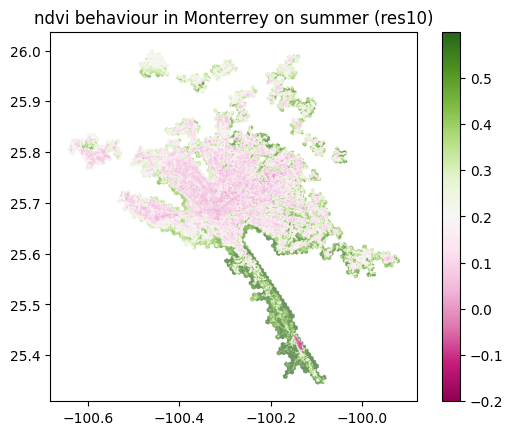

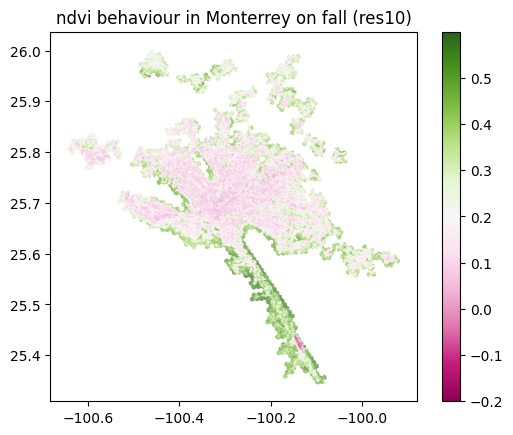

In [19]:
#Iterate over each season
seasons = ['winter', 'spring', 'summer', 'fall']

for current_season in seasons:
    # ---------- Isolate seasonal data ----------
    #Isolate df
    current_raster_dataset = raster_dataset.loc[(raster_dataset.season == current_season)]
    
    #Group by hex id    
    current_analysis = current_raster_dataset.groupby('hex_id').agg({analysis_type:np.mean})
    current_analysis = current_analysis.reset_index()
    
    #Join with geometry
    current_analysis_hex = pd.merge(current_analysis, hex_grid, left_on='hex_id', right_on='hex_id_{}'.format(res))
    
    #GeoDataFrame Format
    current_analysis_hex = gpd.GeoDataFrame(current_analysis_hex, geometry='geometry')
    current_analysis_hex = current_analysis_hex.drop(columns = ['hex_id_{}'.format(res), 'CVEGEO'])
    current_analysis_hex = current_analysis_hex.rename(columns = {'metropolis': 'city'})
    
    
    # ---------- Plot seasonal data ----------
    current_analysis_hex.plot('{}'.format(analysis_type), colorpalette, legend=True, norm=divnorm) #vmin= minvalue, vmax = maxvalue
    
    # ---------- Format ----------
    # Format - Titles
    plt.title('{} behaviour in {} on {} (res{})'.format(analysis_type,city,current_season,res))
    
    #Check
    #average = np.mean(current_analysis_hex.ndmi)
    #print(average)
    
    # ---------- Save Plot ----------
    plt.savefig("../../../output/figures/ndvi_ndmi_marg_bycity/{}/{}_{}_{}.svg".format(city.lower(),analysis_type,city.lower(),current_season))